In [1]:
from glob import glob
import pandas
import numpy
import pylab
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [2]:
def norm_df(thresh_file): #normalize the dataframes using the reference
    a = pandas.read_csv(thresh_file, sep='\t', index_col='#')
    columns = a.columns
    ref_col = columns[-1]
    for col in a.columns[:-1]:
        new_col_name = col.split('_scaled_aligned')[0]+'_normRef'
        a[new_col_name] = a[col]/a[ref_col]
    a['element_name'] = a.index
    a['RNA'] = a['element_name'].str.contains('h')
    a['Protein'] = ~a['RNA']
    return a

In [3]:
def final_df(a): #normalize to the max of the 'occupied proteins/rna or the max in the particular row

    all_cols = a.columns
    data_cols = []
    for c in all_cols:
        if '_normRef' in c:
            data_cols.append(c)
    
    prot_vals = a[a['Protein']==True][data_cols]
    median_prot_val = numpy.median(prot_vals[(prot_vals >= 0.65).all(axis=1)].values)
    rna_vals = a[a['RNA']==True][data_cols]
    median_rna_val = numpy.median(rna_vals[(rna_vals >= 0.75).all(axis=1)].values)
    a['med_value'] = a['RNA']*median_rna_val+a['Protein']*median_prot_val
    data_cols.append('med_value')
    for col in data_cols:
        a[col+'_final'] = a[col]/a[data_cols].max(axis=1)
    return a

In [4]:
def calc_thresh_dict(root_name): #make a threshold_dictionary (protein->map_name->list of occupancies by threshold)
    thresh_files = sorted(glob('./'+root_name+'/*.txt'))
    thresholds = [i.split('.tx')[0].split('_')[-1] for i in thresh_files]
    thresh_dict = {} # find the thresholds based on the file names, put in the x-axis field
    thresh_dict['x_axis'] = thresholds
    
    test = norm_df(thresh_files[0])
    test = final_df(test) #make in initial dataframe to pull out the relevent fields
    all_cols = test.columns
    
    final_occupancies = []
    for c in all_cols:
        if '_final' in c: #figure out the names of the occupancy colums
            final_occupancies.append(c)
    final_occupancies.remove('med_value_final')

    all_prots = test.index
    for p in all_prots:
        thresh_dict[p] = {} #figure out the names of the proteins and initialize the dictionary accordingly
        for col in final_occupancies:
            thresh_dict[p][col] = []

    all_df = []
    for tf in thresh_files:
        a = norm_df(tf)
        a = final_df(a)
        all_df.append(a.copy())
        for col in final_occupancies:
            for p in all_prots:
                thresh_dict[p][col].append(a.loc[p][col]) #fill in the thresh_dictionary
    return thresh_dict

In [11]:
def plot_thresh(root_name, save_fig=False):
    thresh_dict = calc_thresh_dict(root_name)
    to_plot = sorted(thresh_dict.keys())

    for i in range(8):
        f = pylab.figure(figsize=(20,27.5))
        for j in range(20):
            a = f.add_subplot(4,5,j+1)
            for model in sorted(thresh_dict['uL2'].keys()):
                a.plot(thresh_dict['x_axis'], thresh_dict[to_plot[i*8+j]][model], label=model)
                a.set_title(to_plot[i*8+j])
                a.set_ylim(0,1.5)
                if j==0:
                    a.legend()
        if save_fig:
            pylab.savefig('./'+root_name+'_'+str(i)+'.png')
            pylab.savefig('./'+root_name+'_'+str(i)+'.pdf')

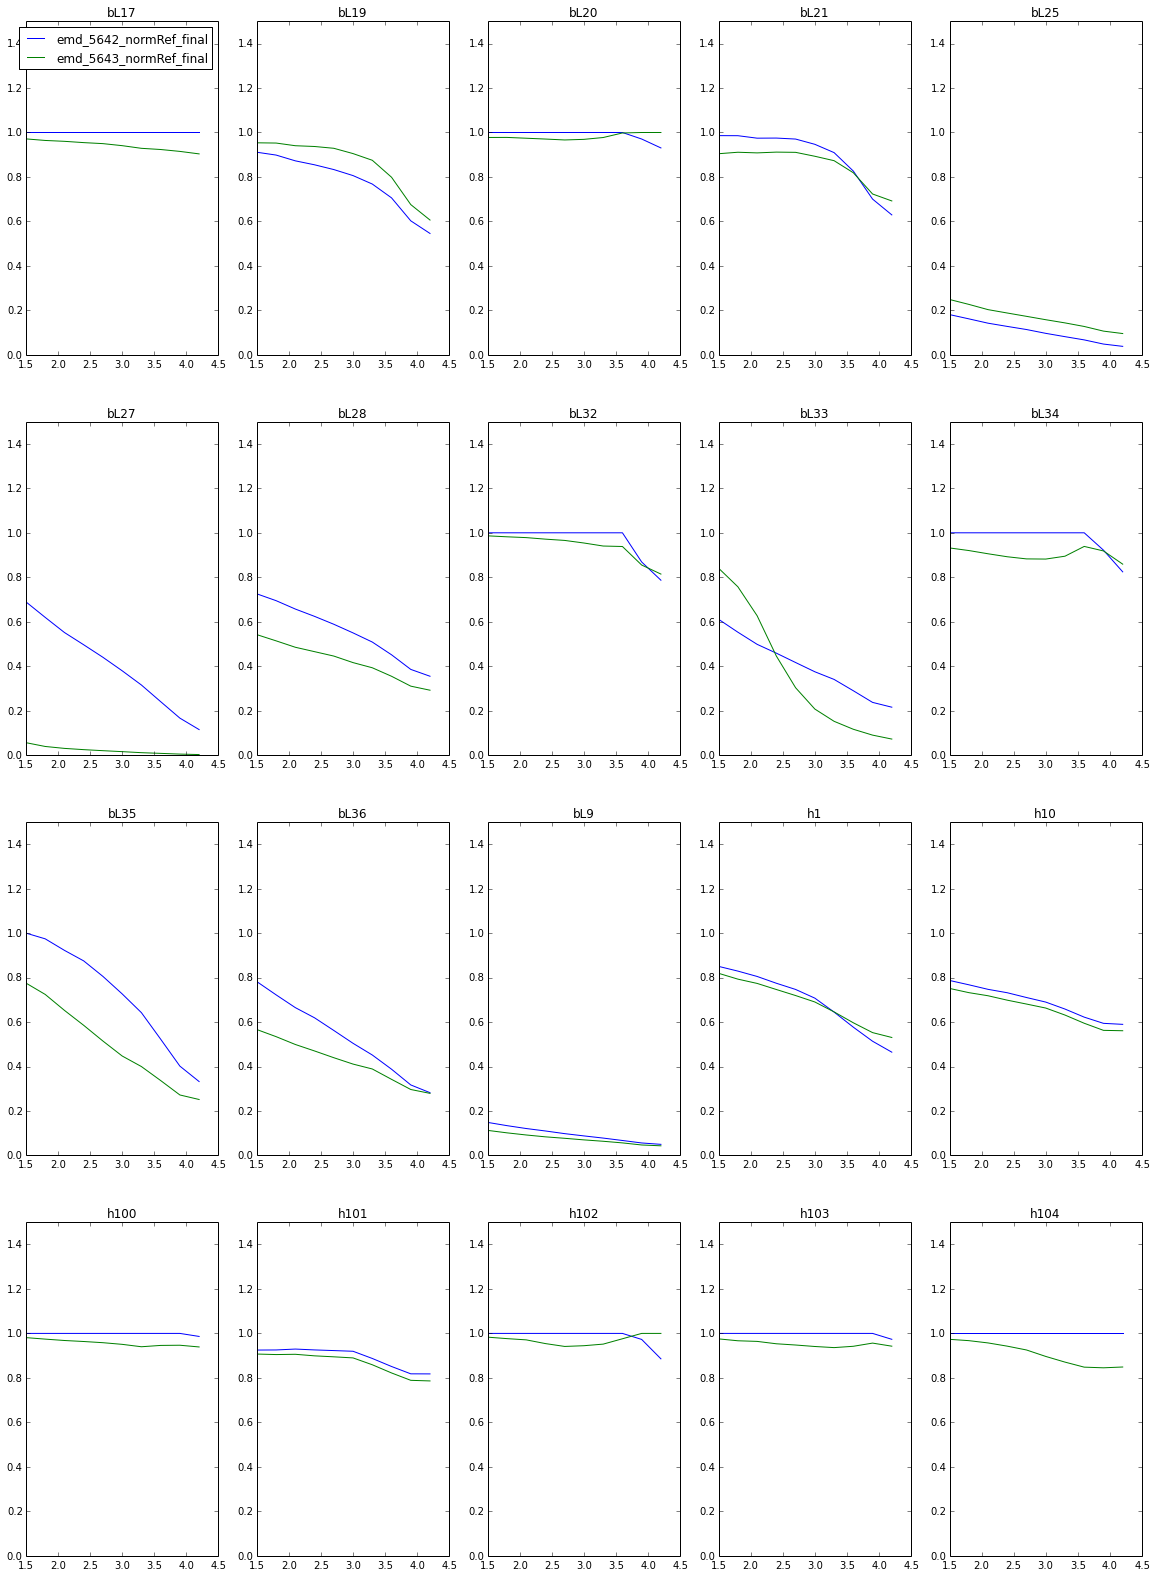

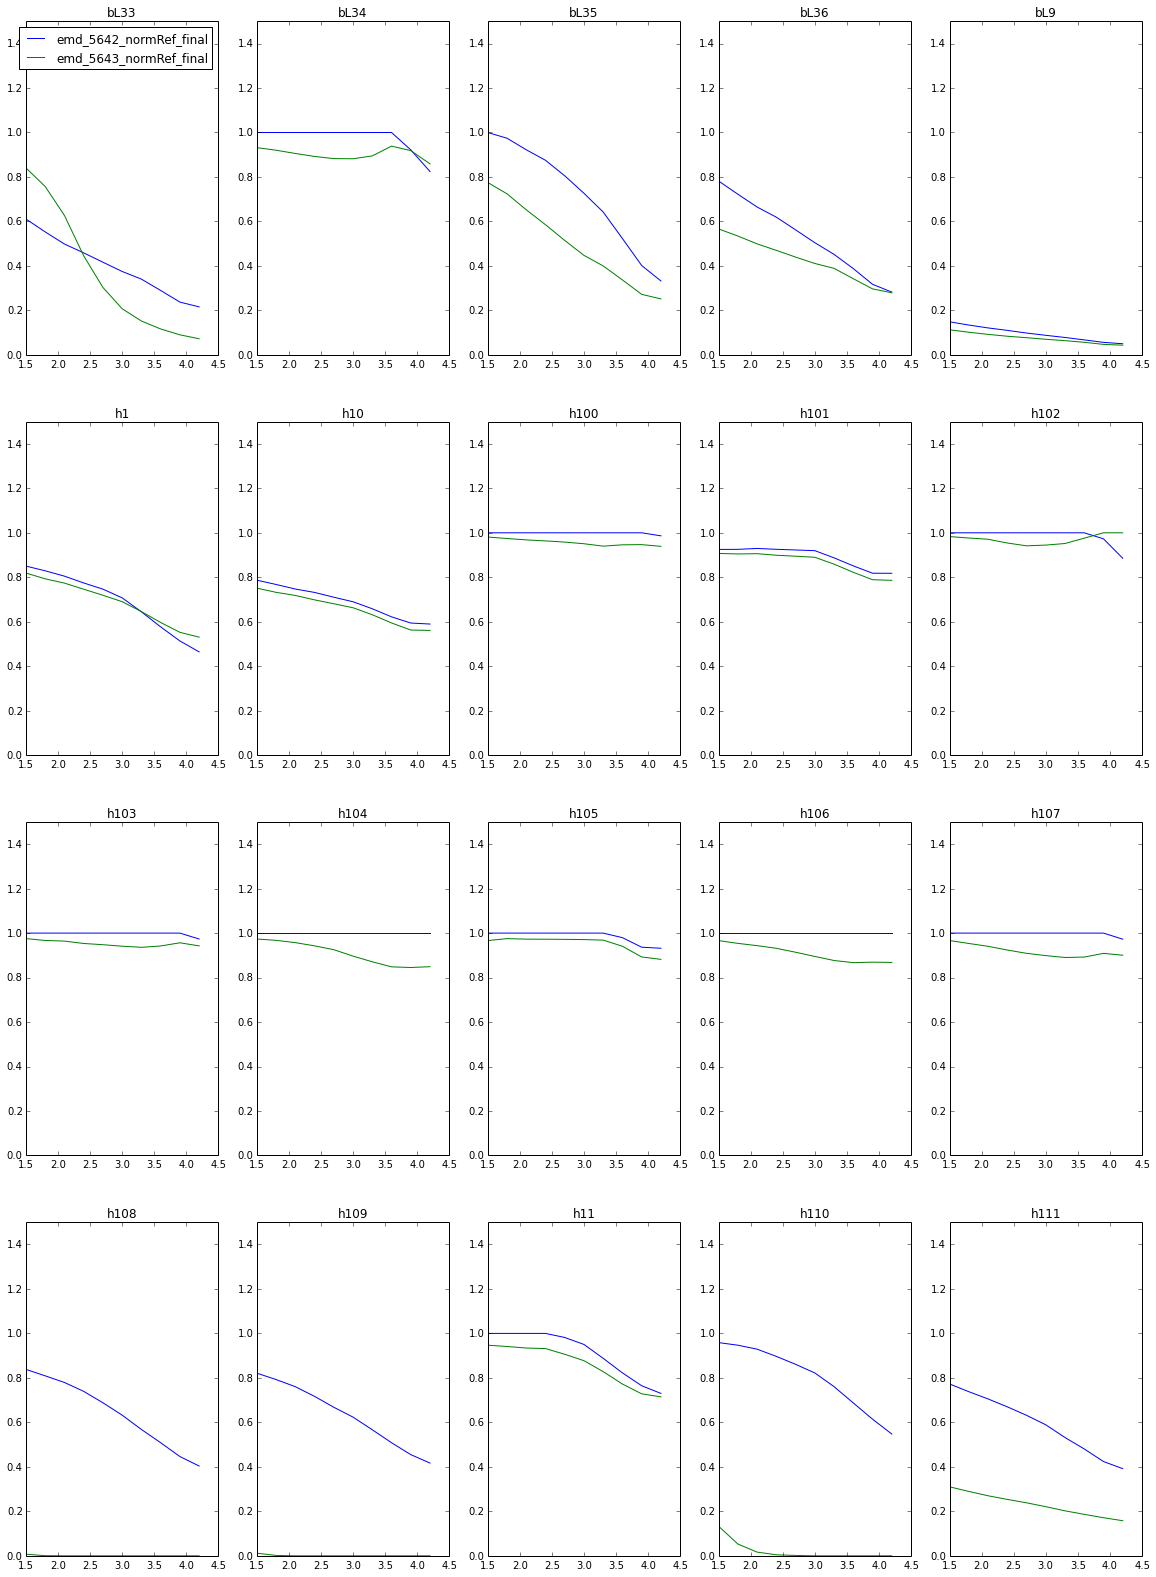

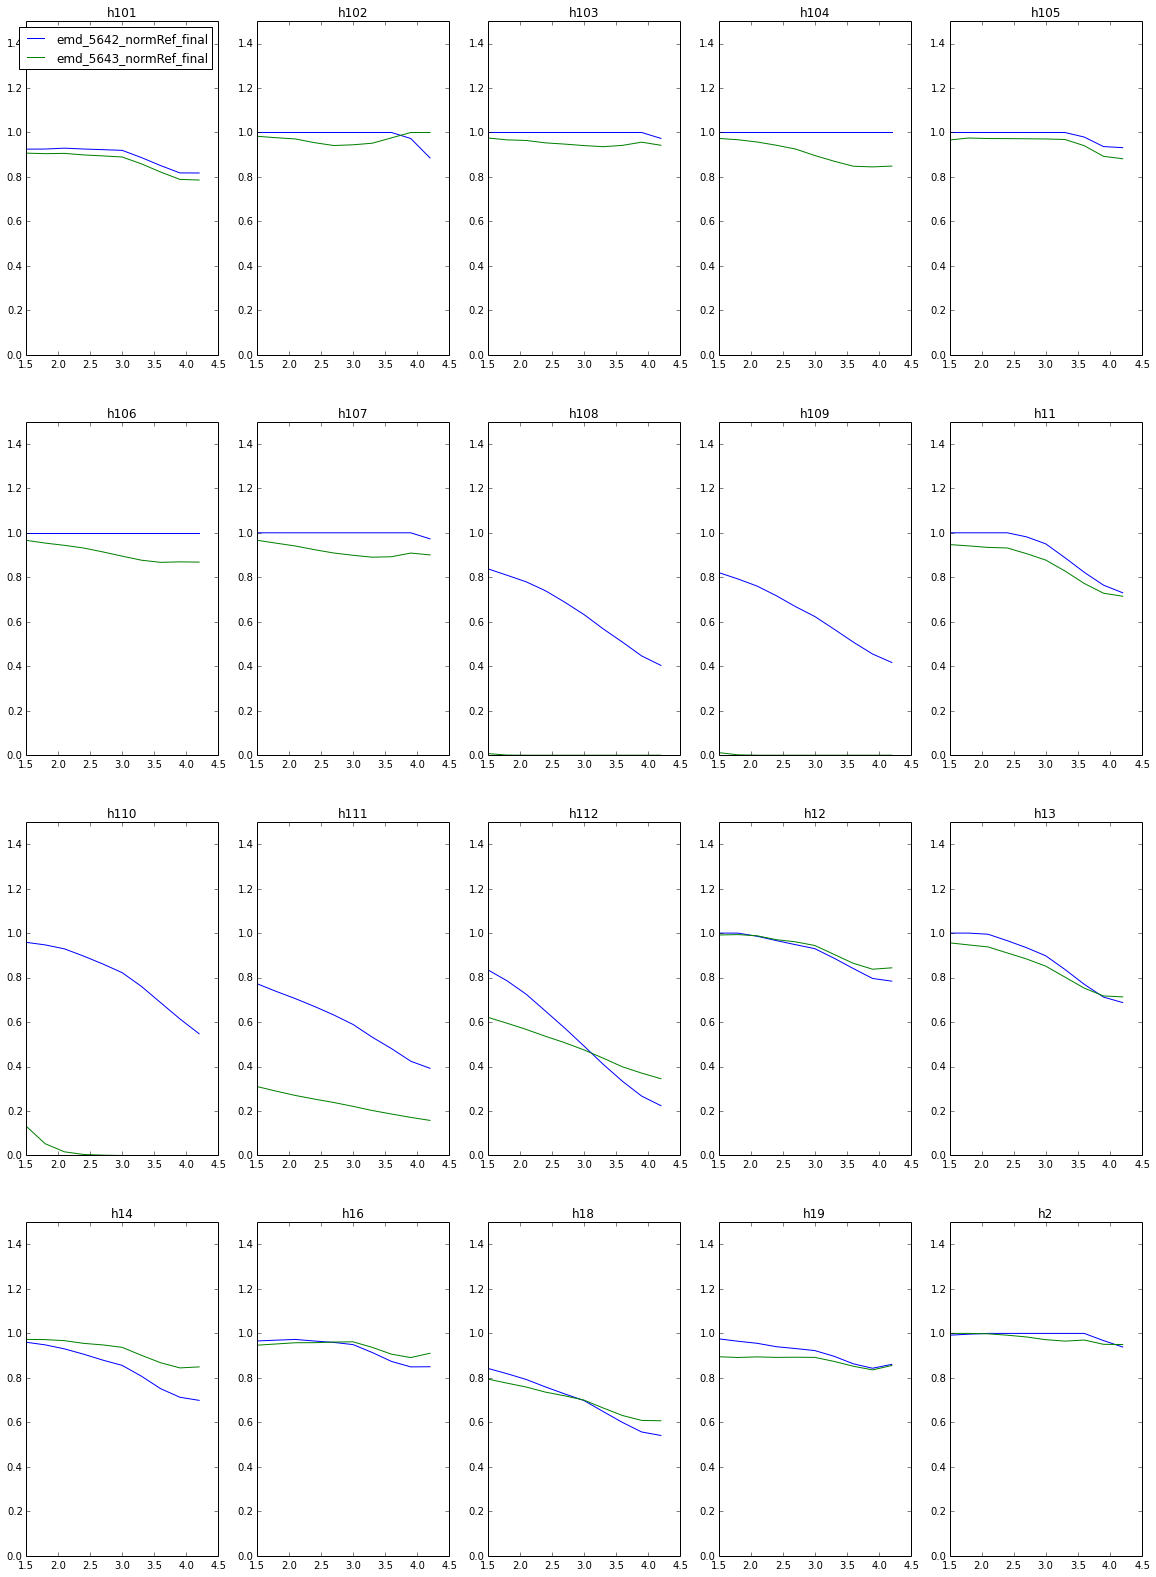

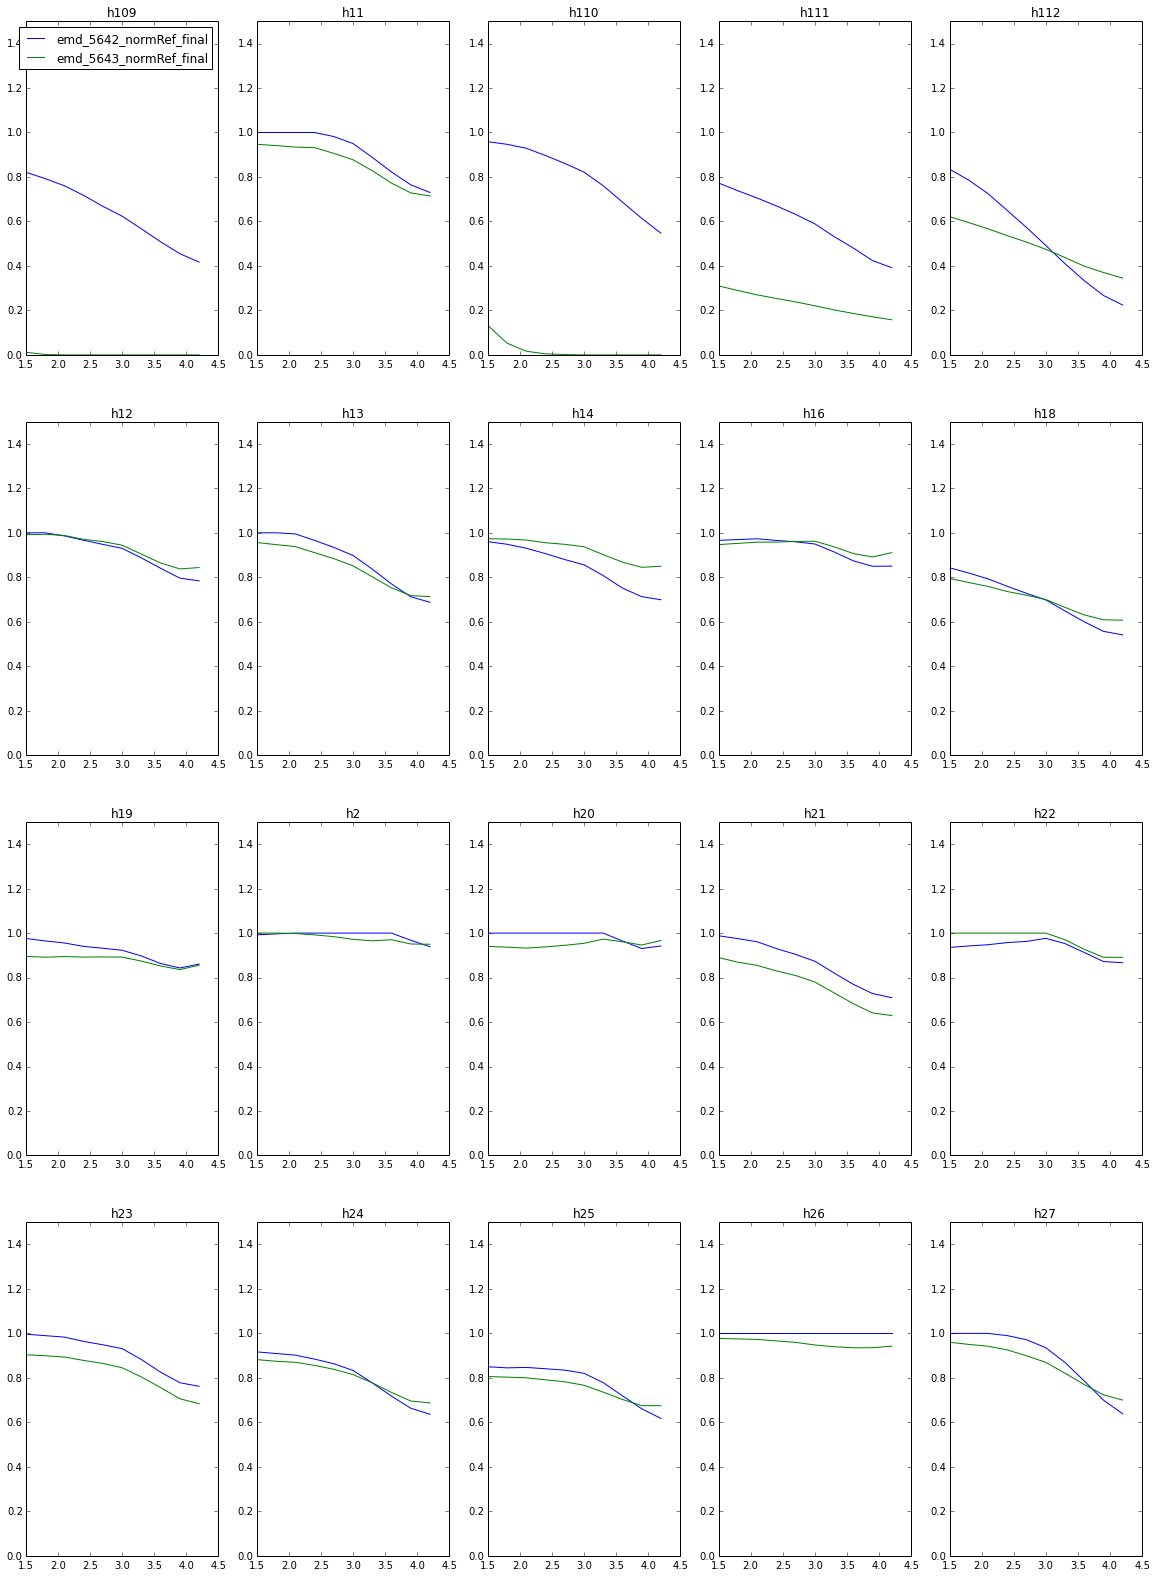

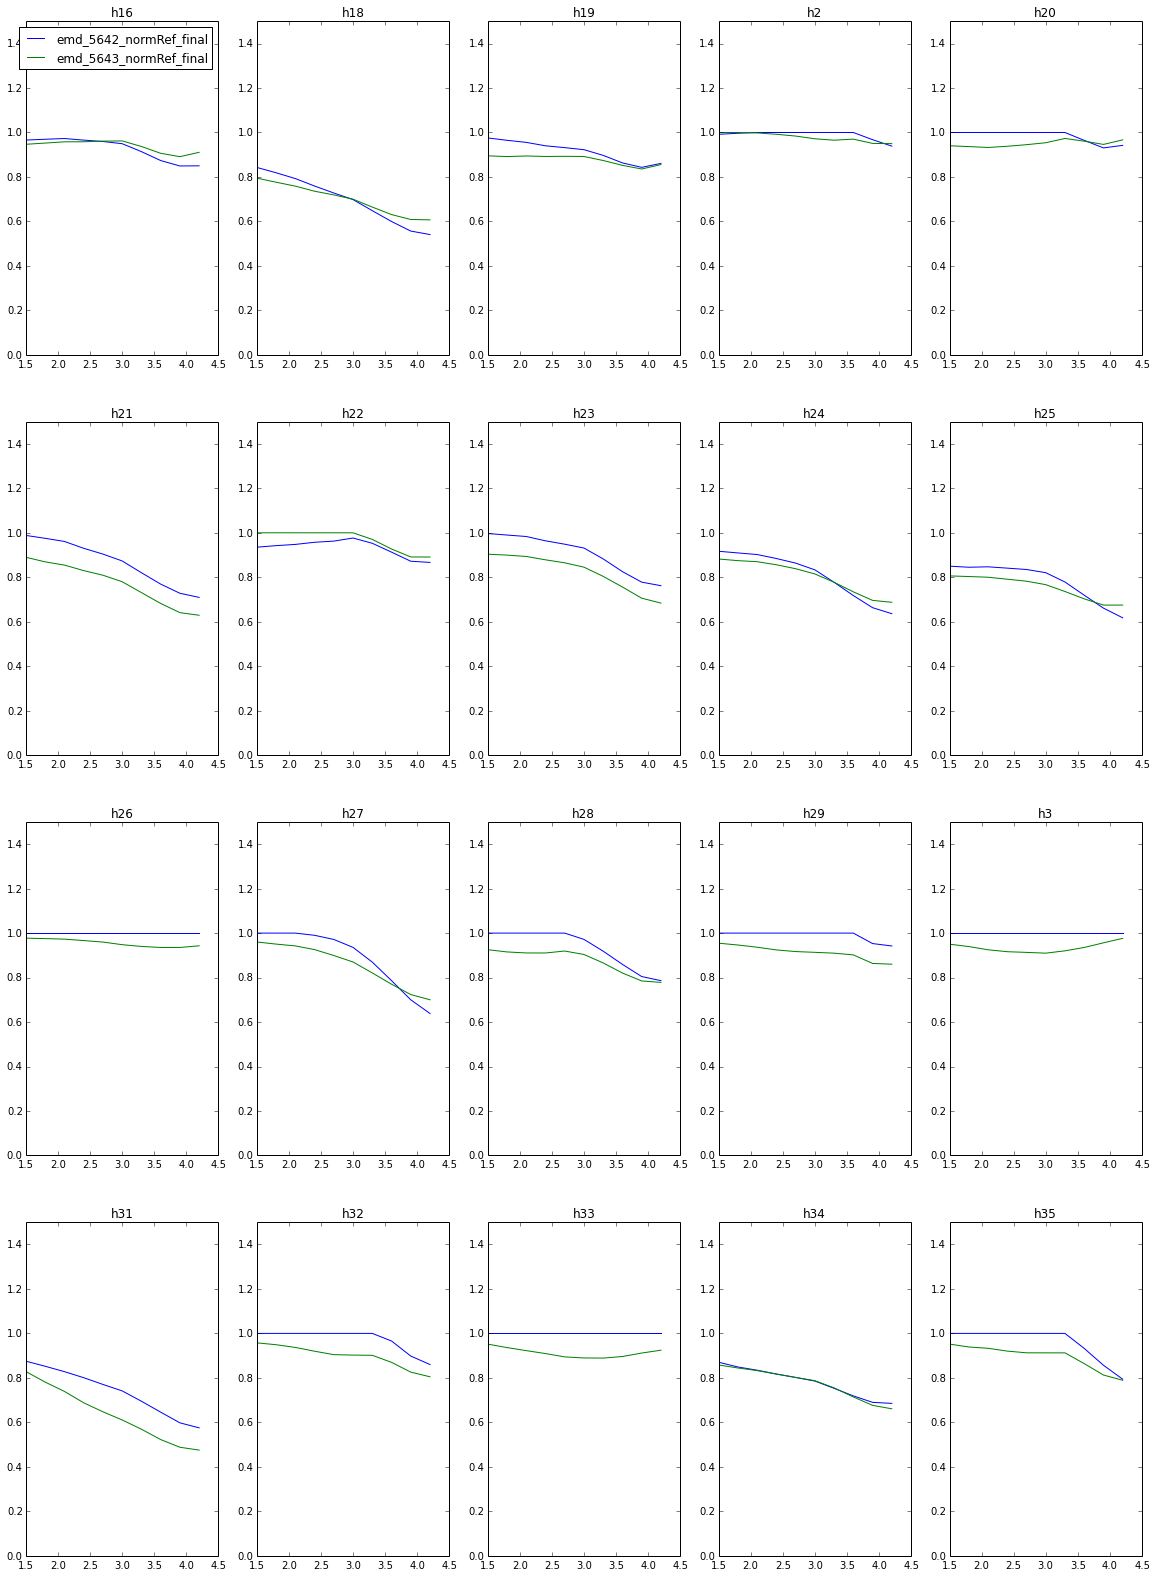

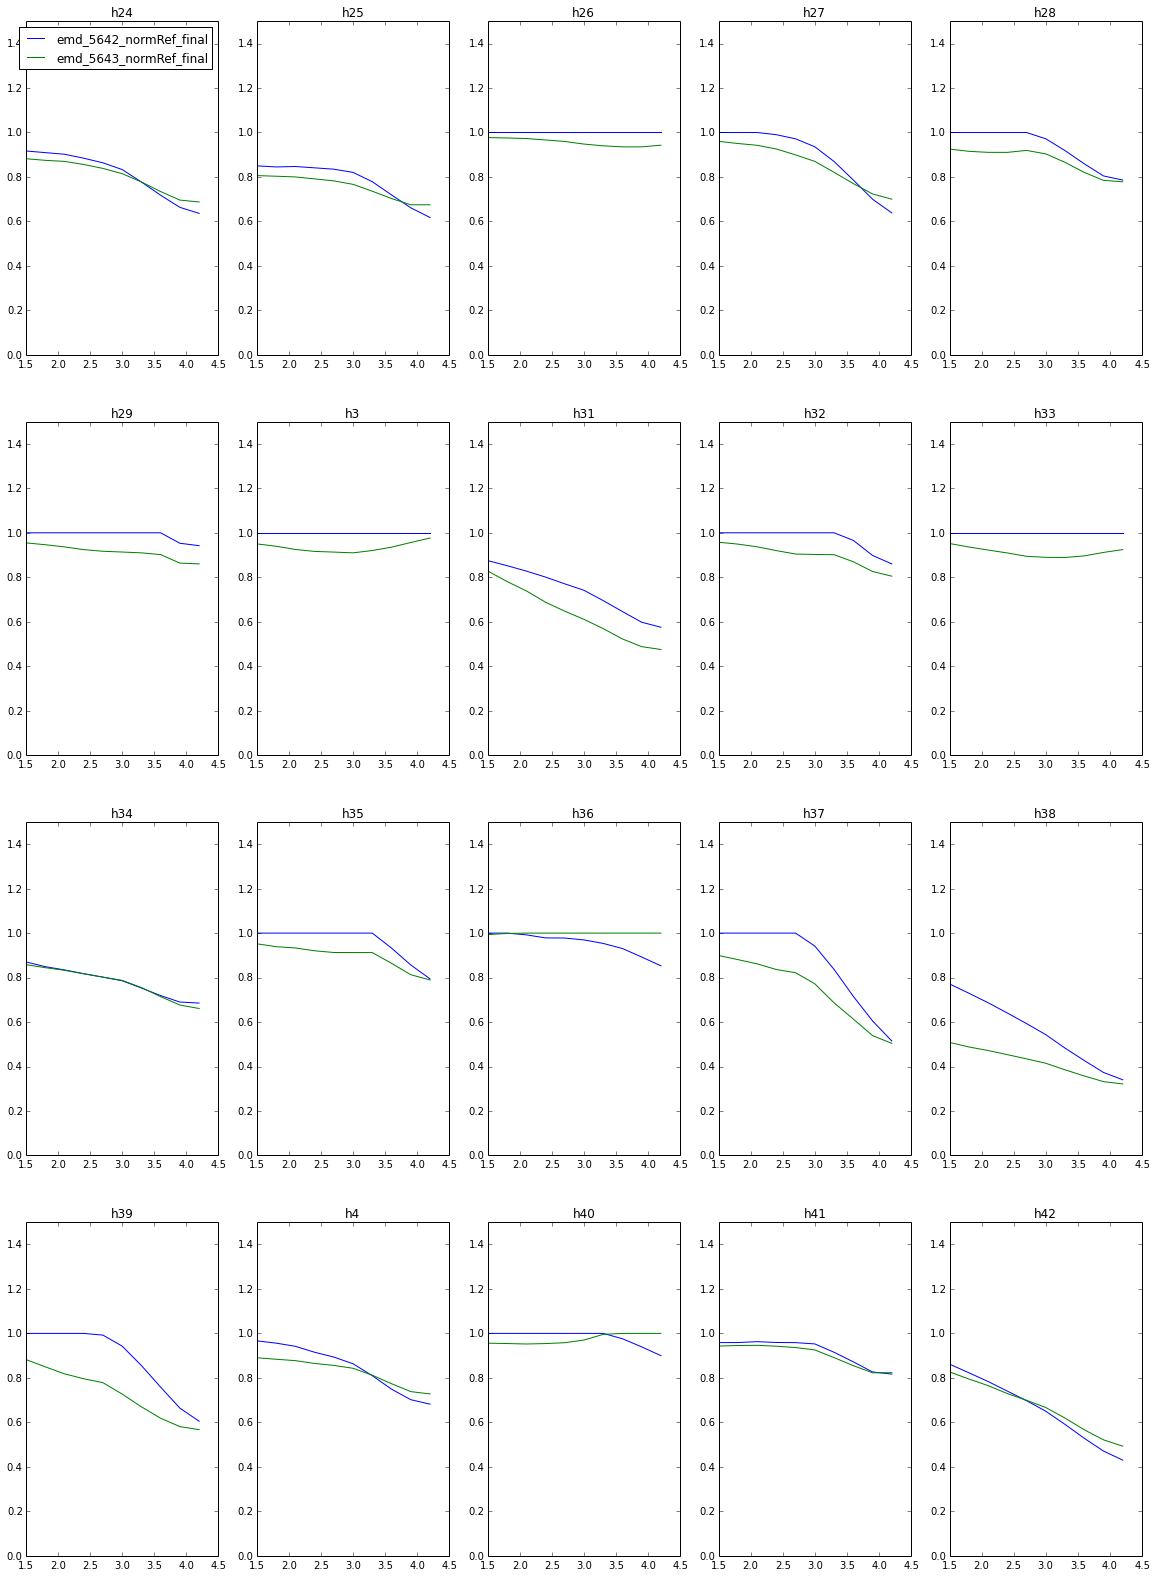

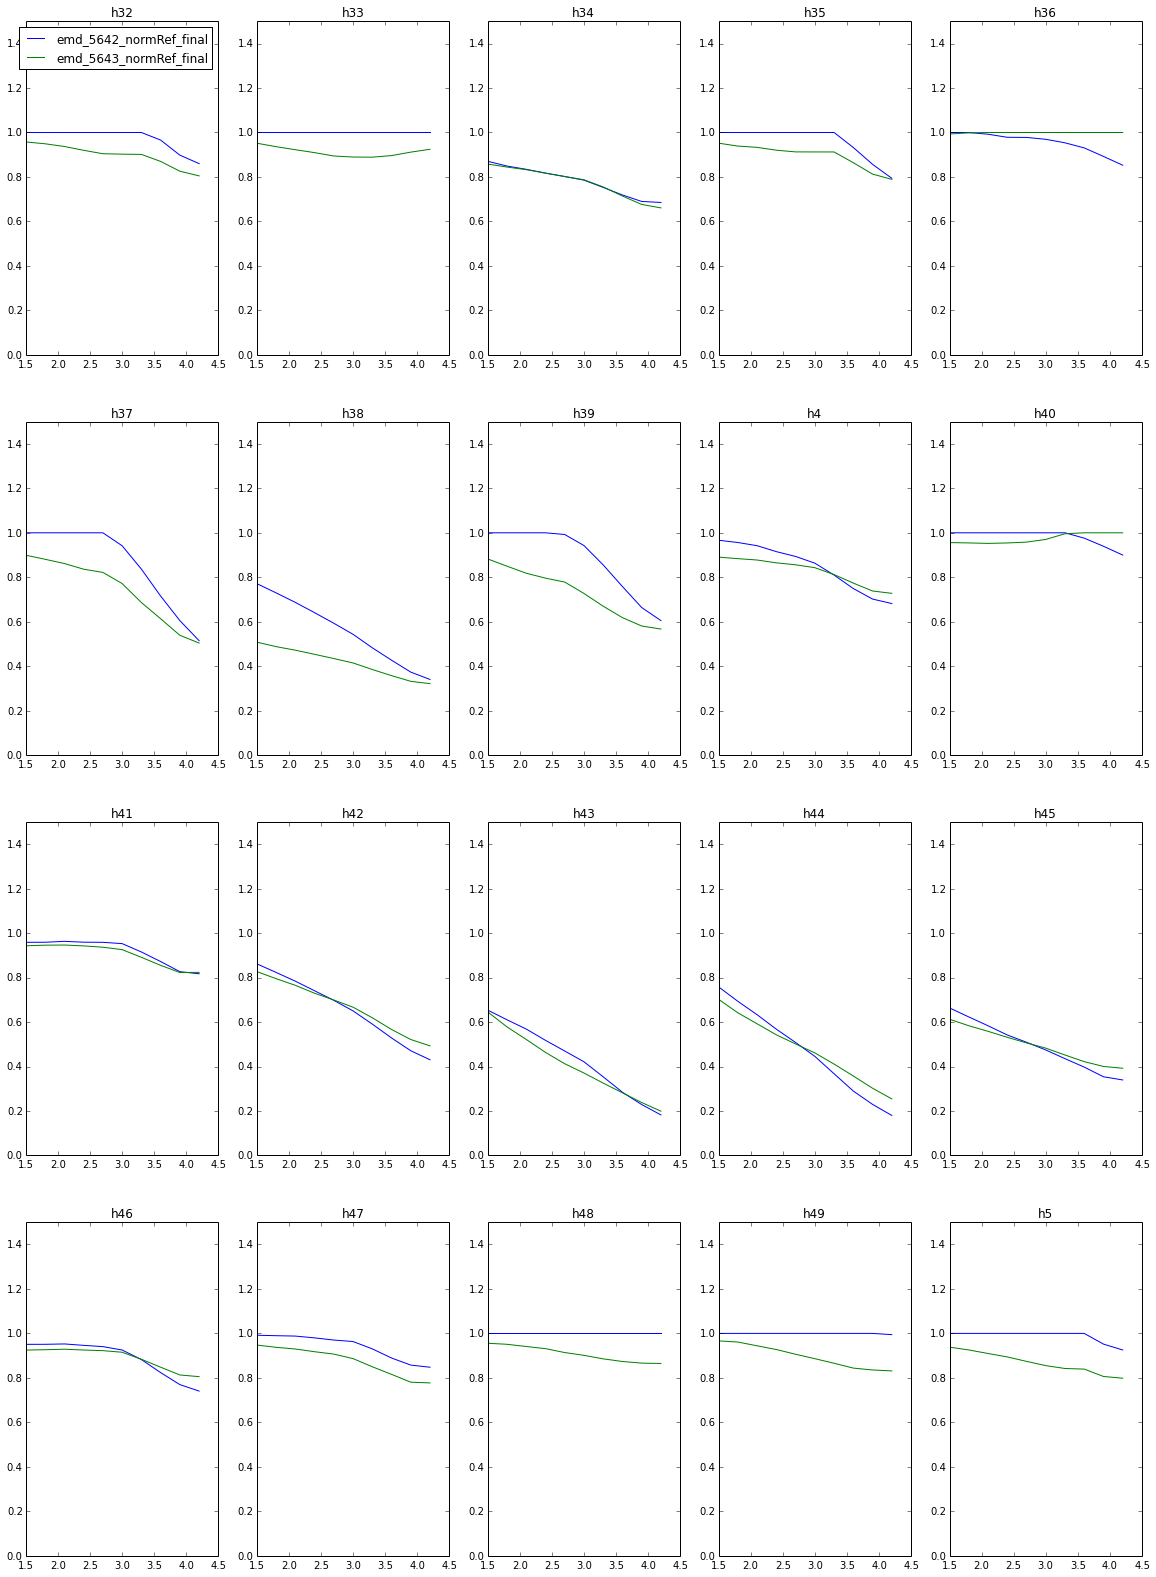

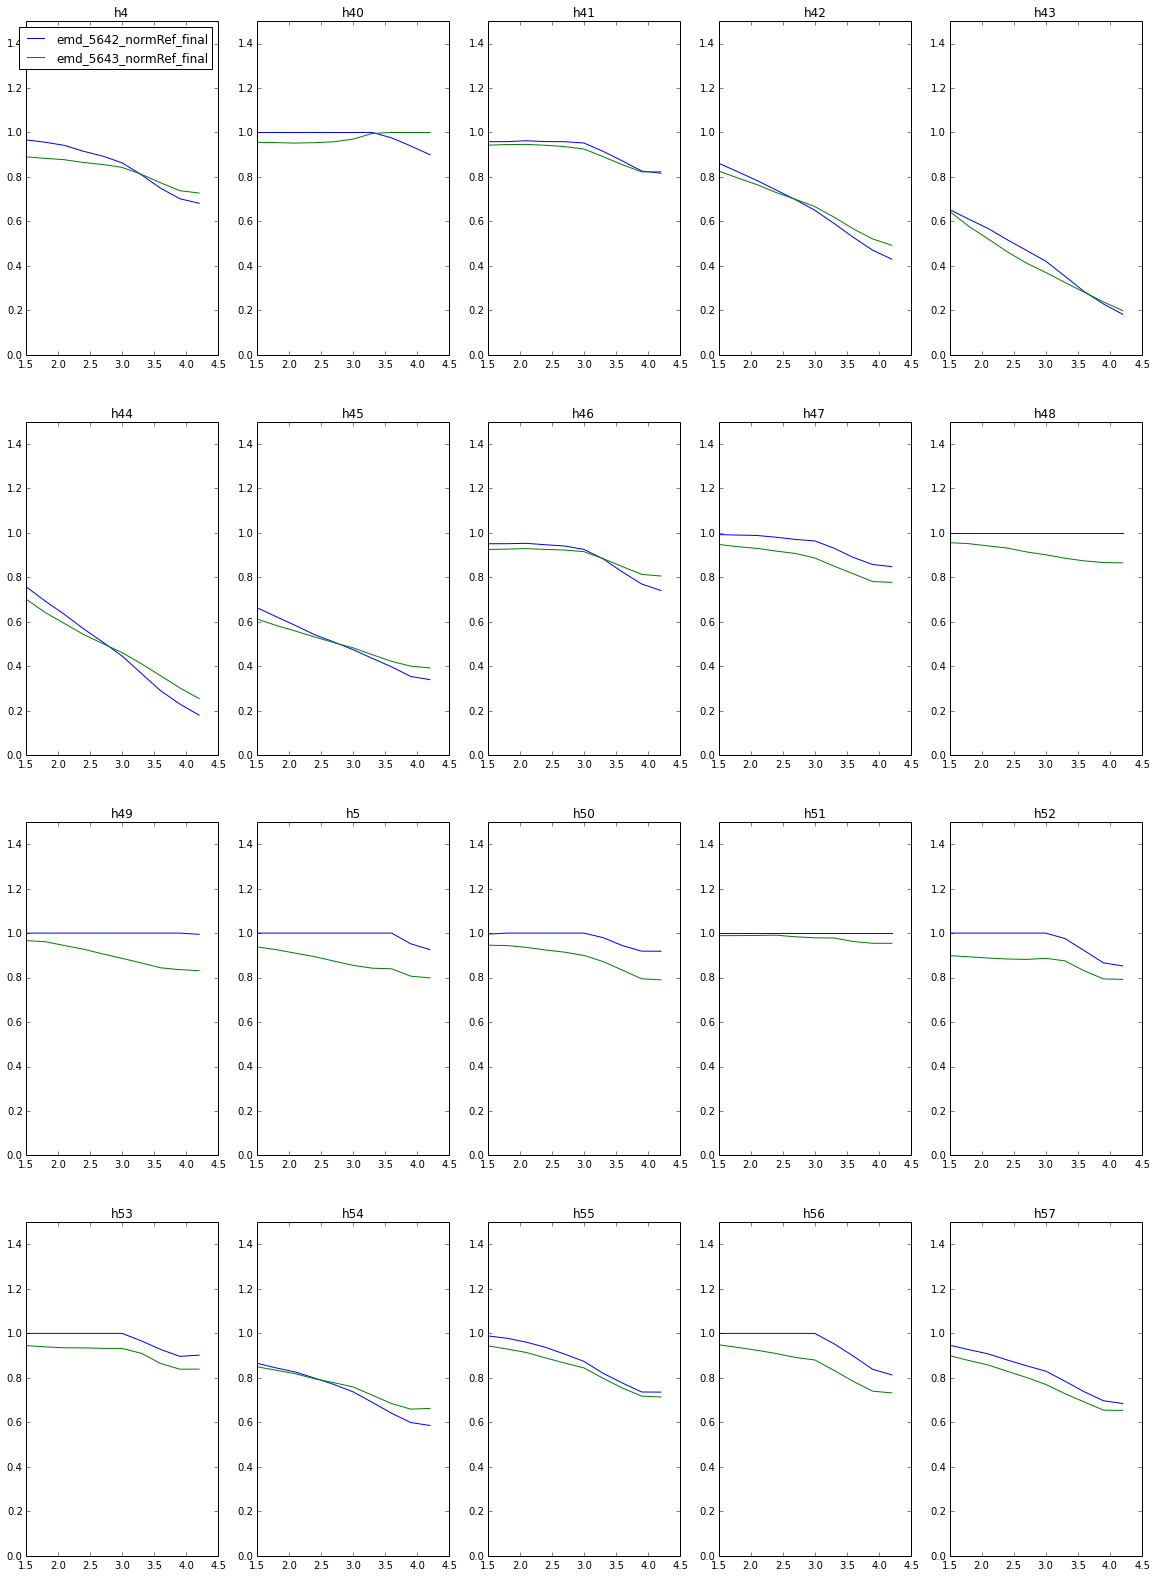

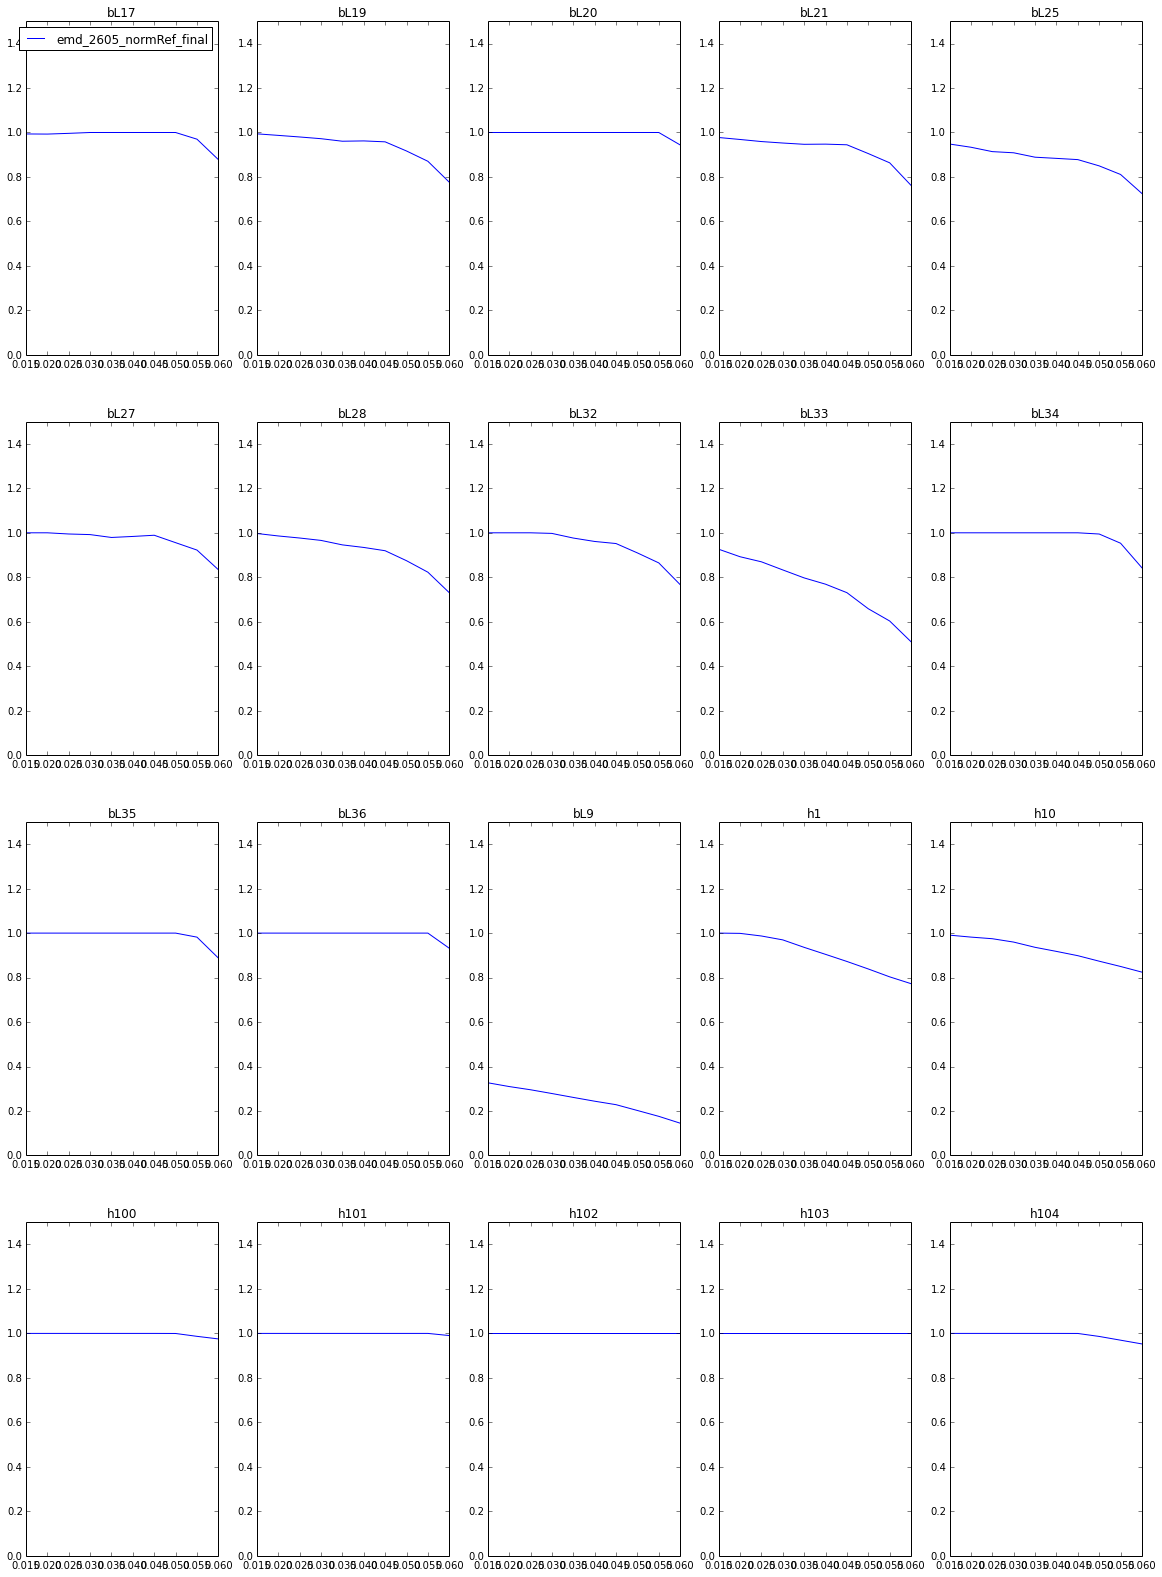

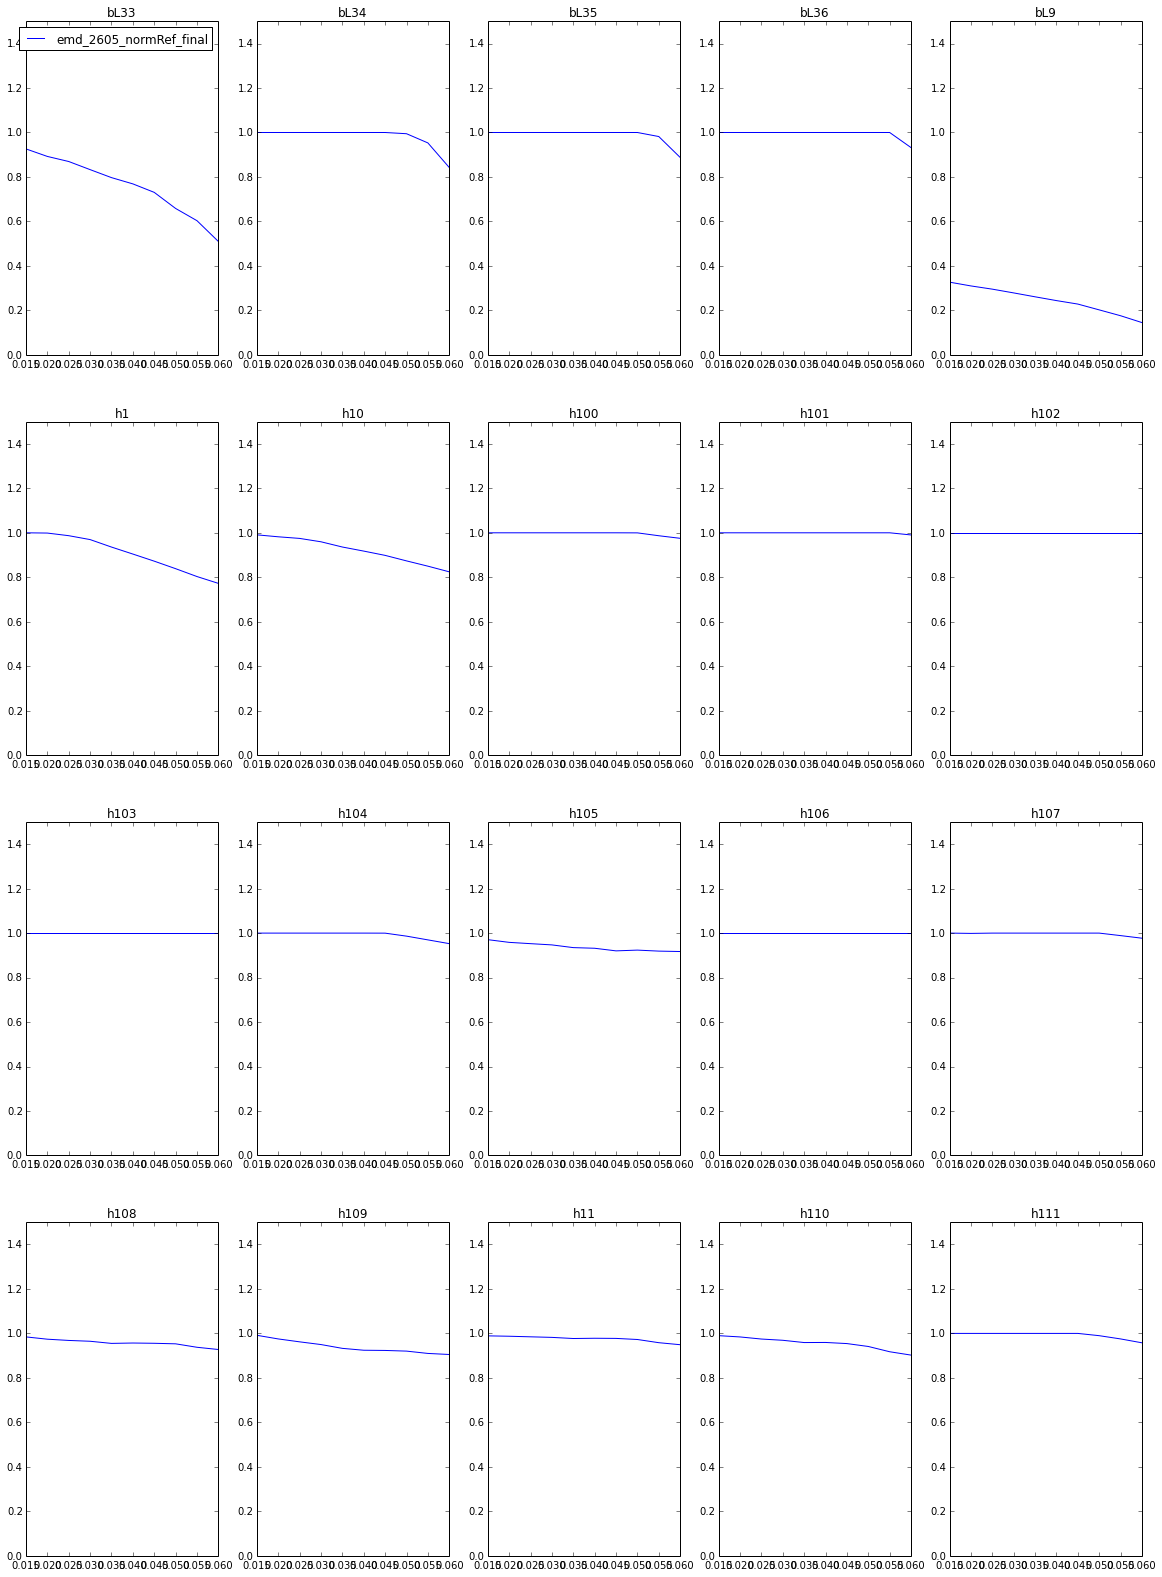

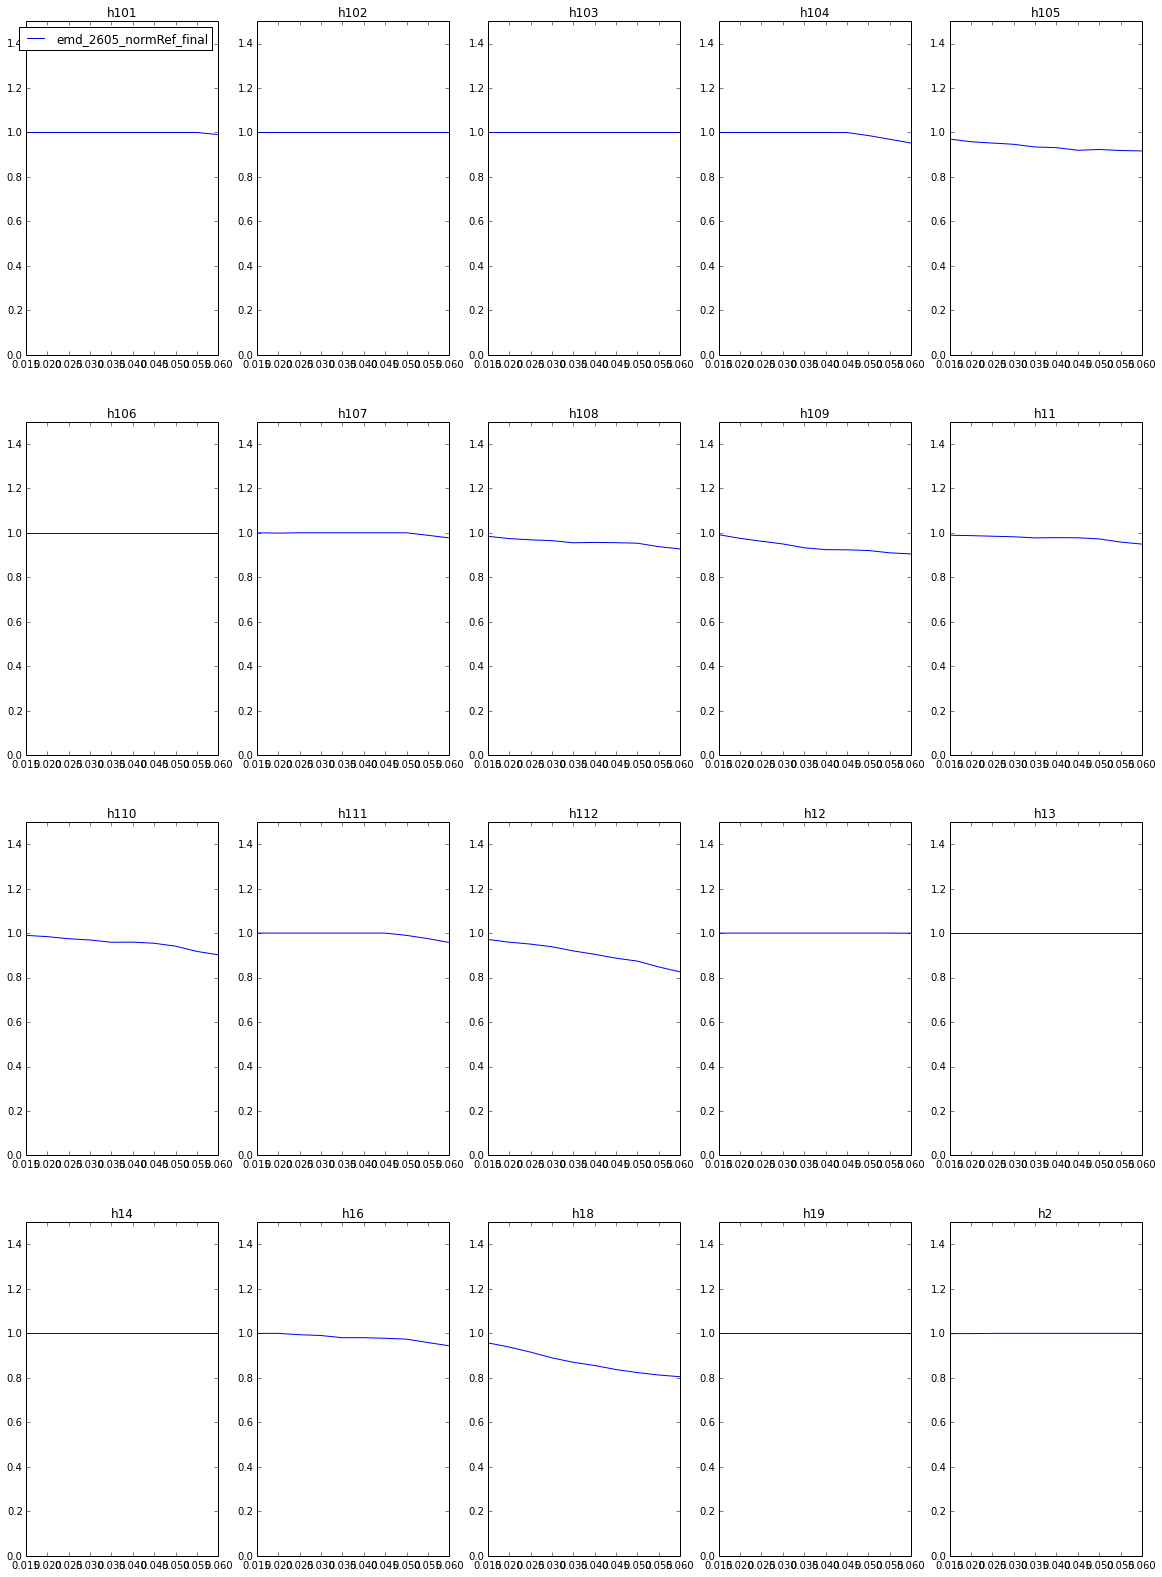

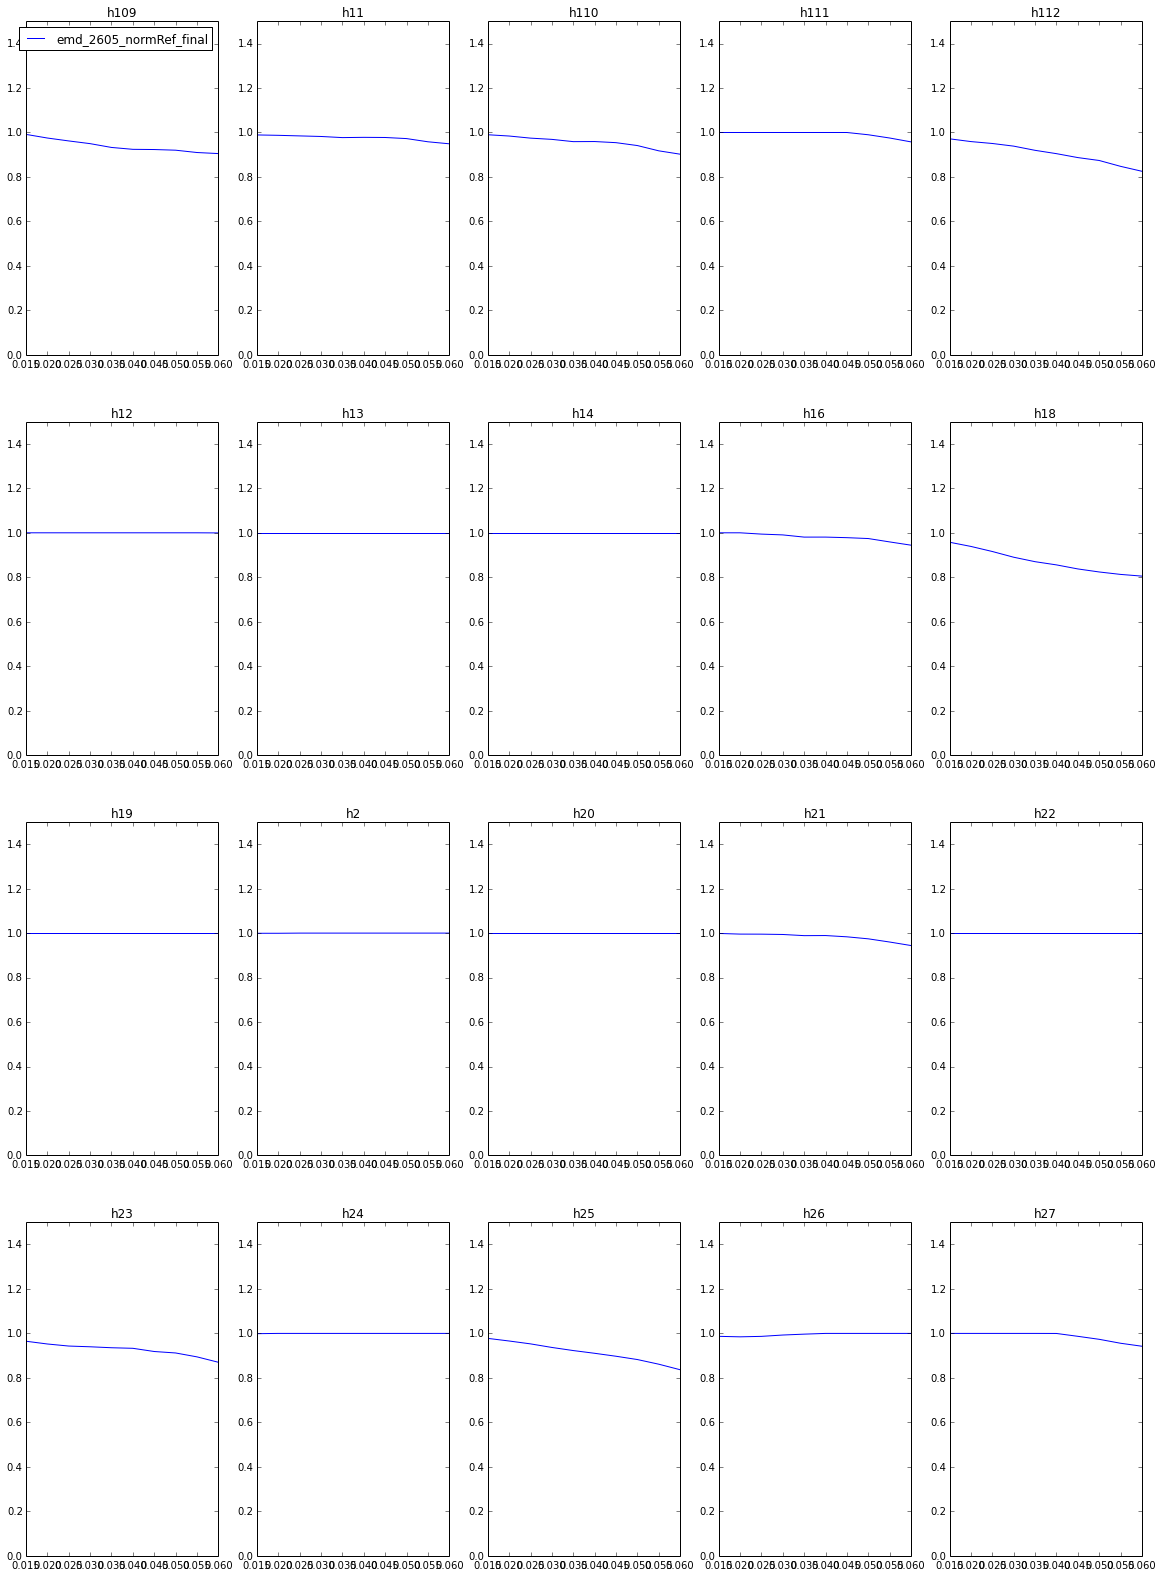

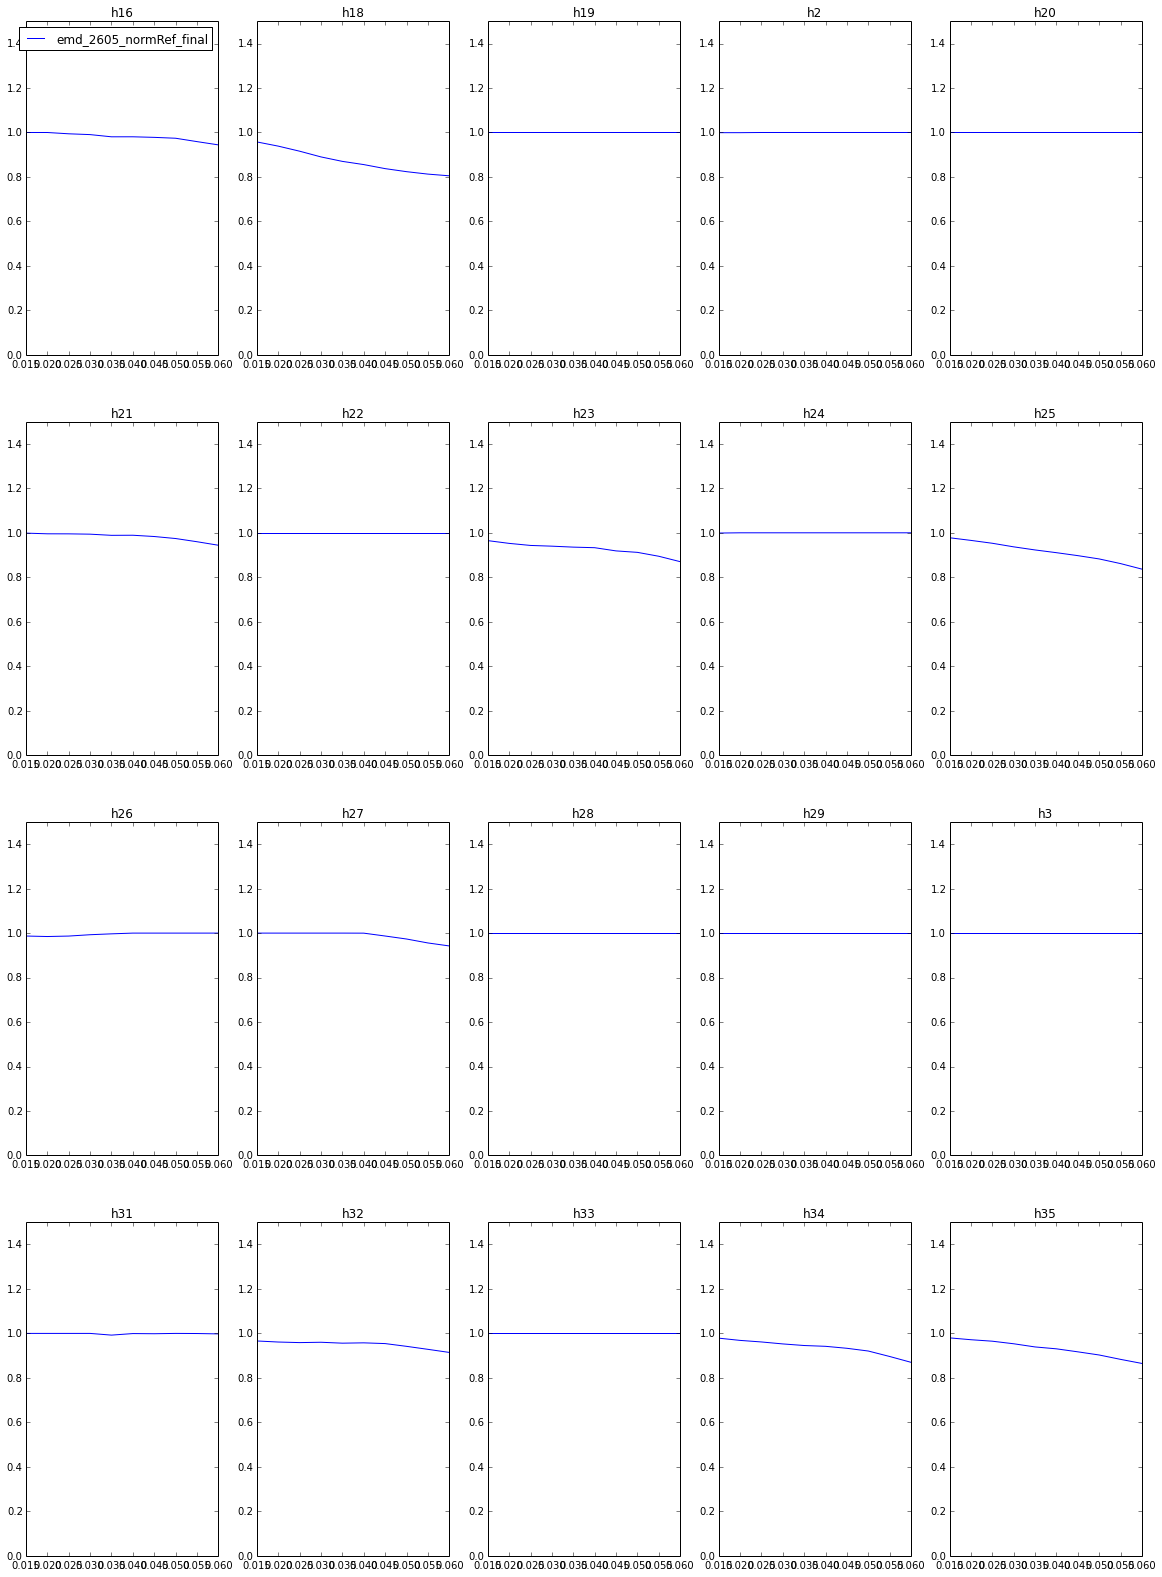

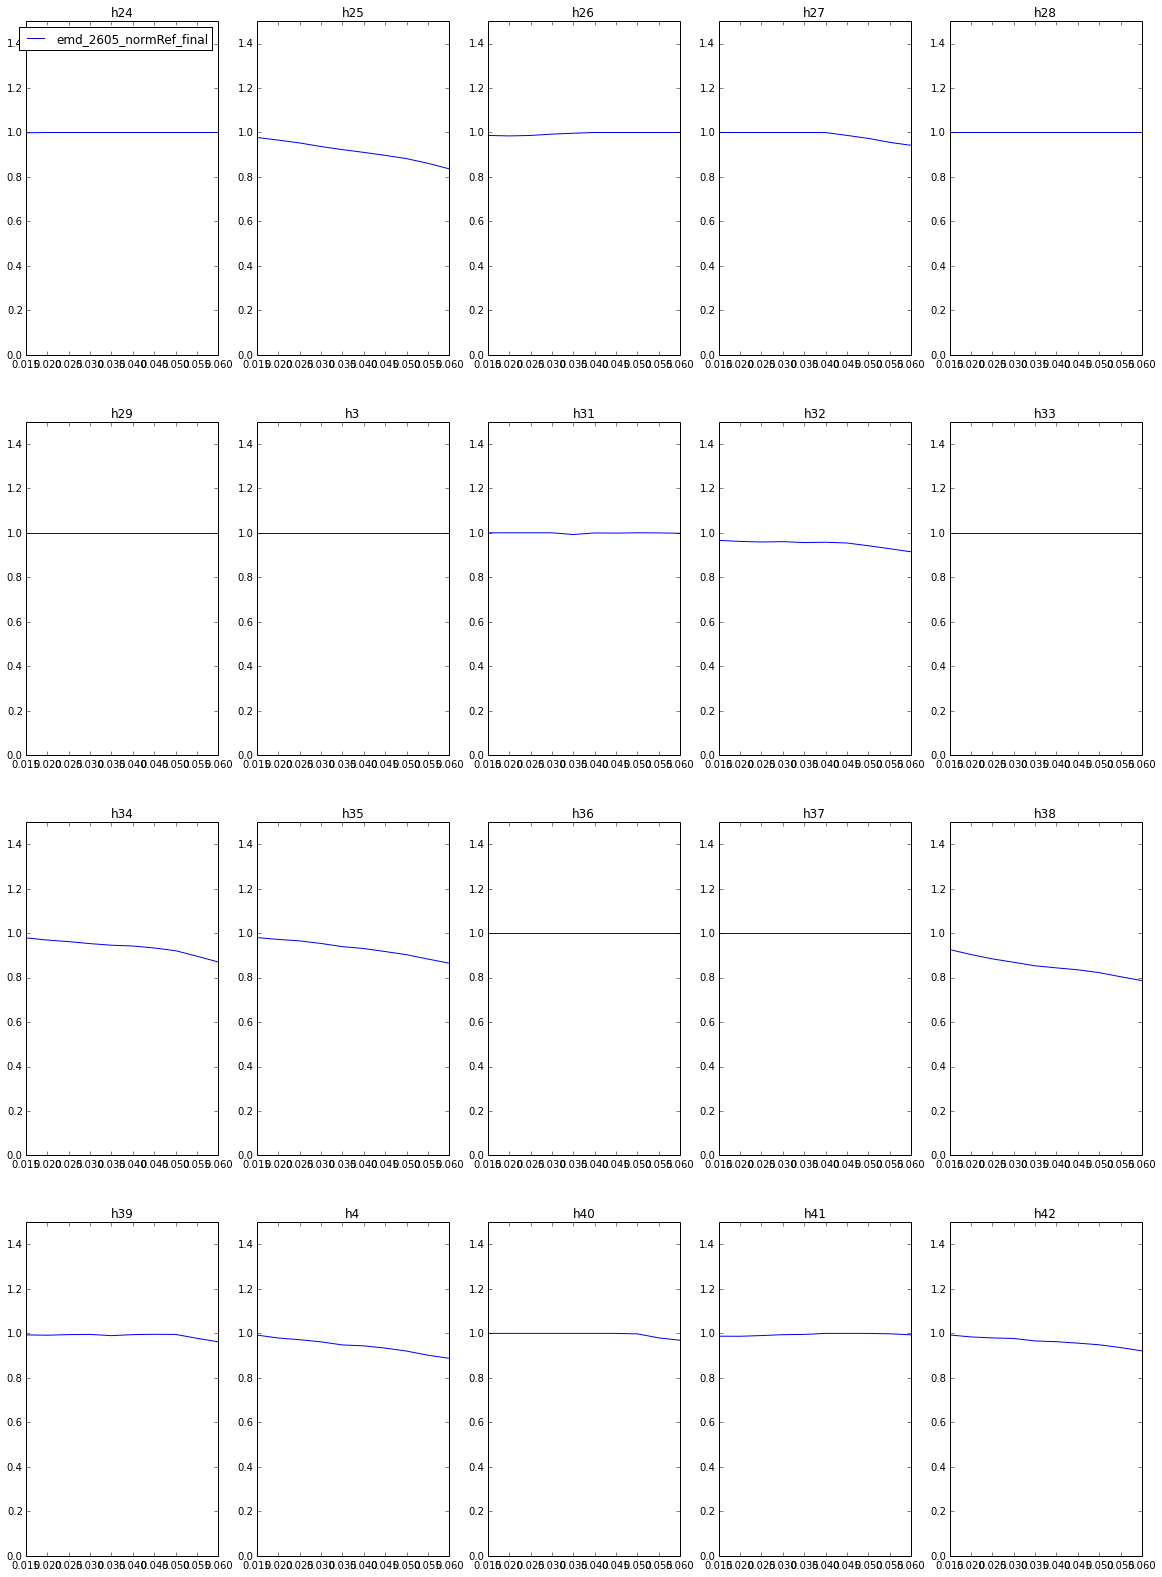

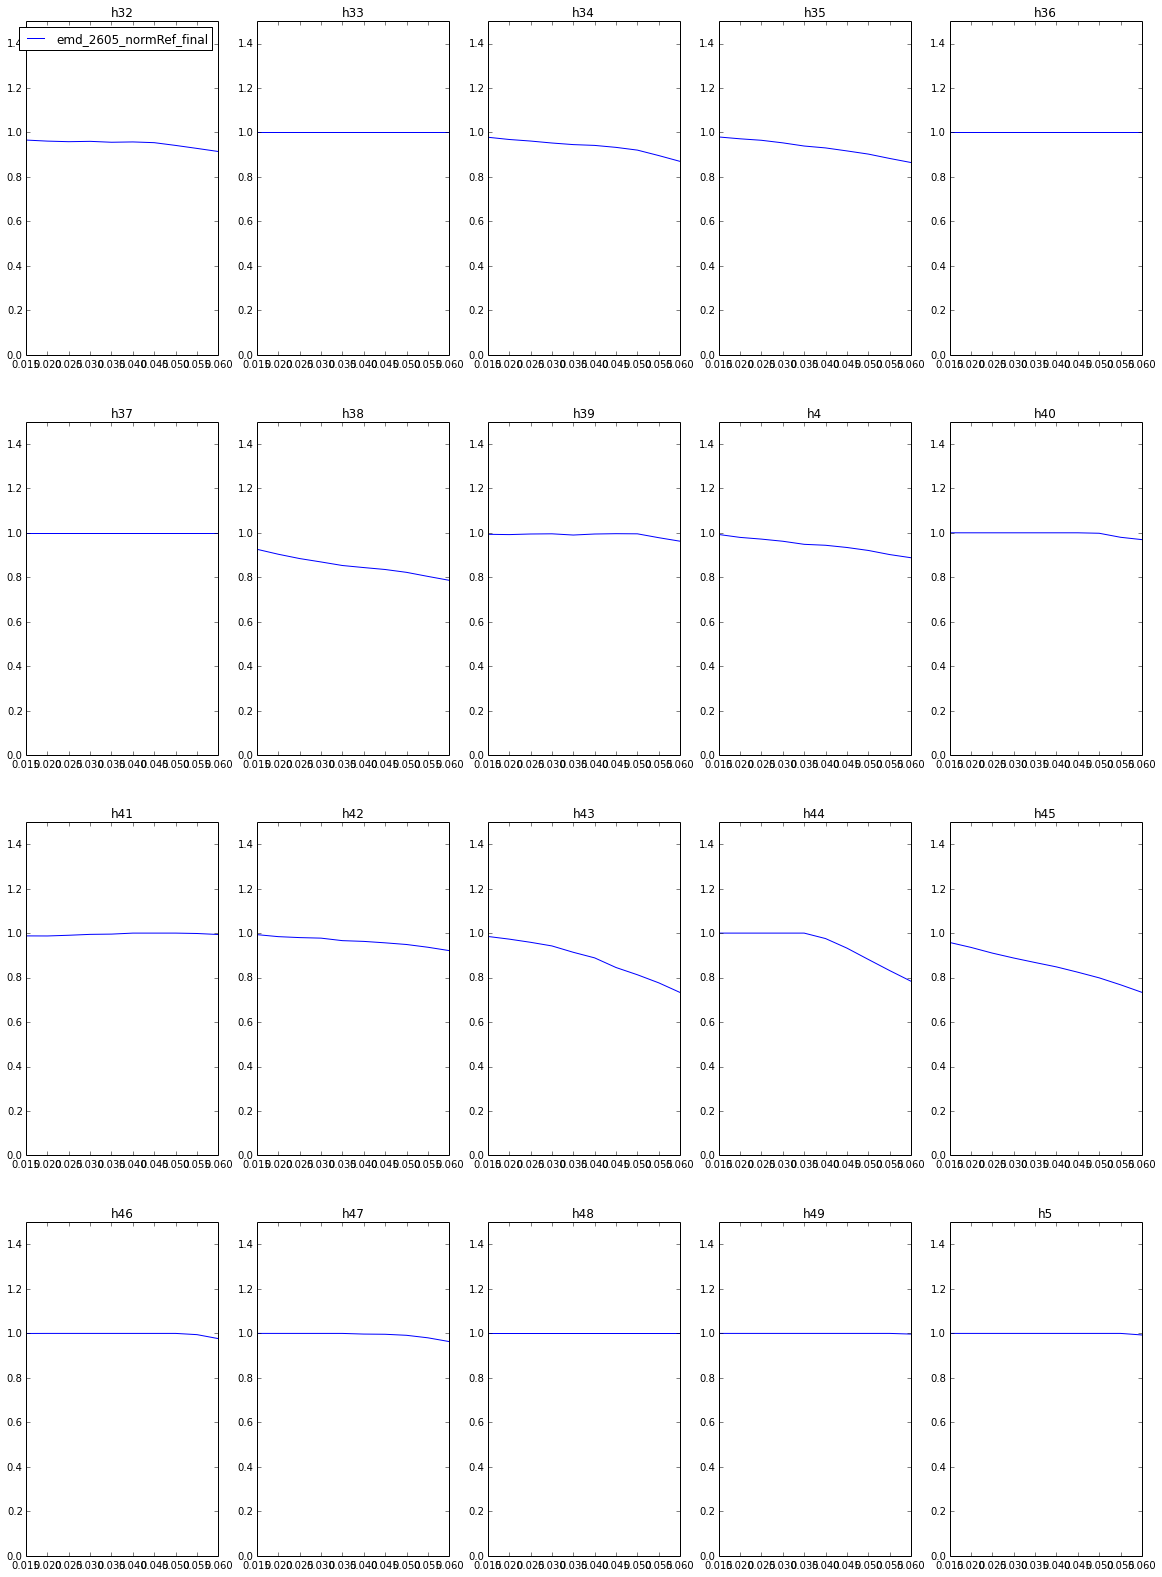

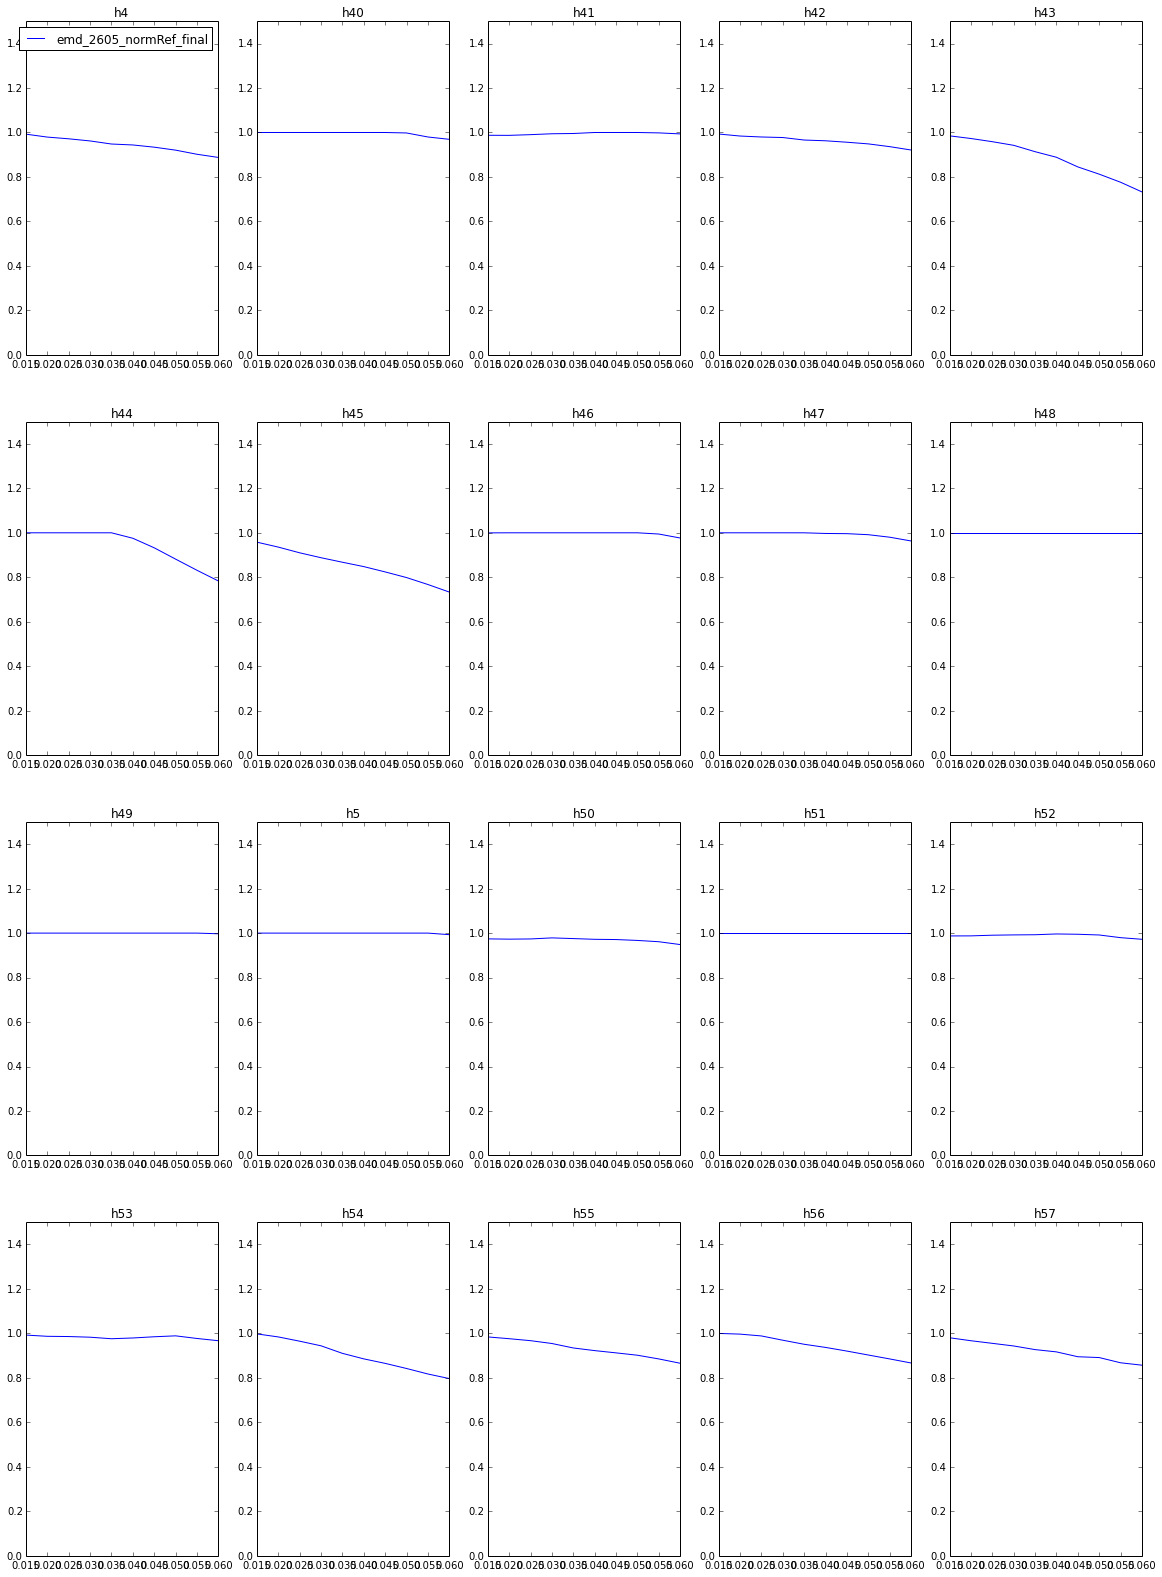

In [12]:
root_names = [i[2:] for i in glob('./*_gao')]
for root_name in root_names:
    plot_thresh(root_name, save_fig=True)